# Árbol de decisión

En este notebook clasificaremos si una instancia tiene alto poder adquisitivo mediante árboles de decisión.

Se utilizarán dos preprocessings diferentes: uno con las variables utilizadas en la primera parte del trabajo práctico y otro utilizando todas las variables posibles del data frame pero antes habiendo equilibrado la cantidad de instancias 1 y 0...

In [1]:
# Modelo
from sklearn.tree import DecisionTreeClassifier

# Entrenamiento
from sklearn.model_selection import train_test_split, GridSearchCV

# Métricas
from sklearn.metrics import plot_roc_curve, classification_report, plot_confusion_matrix, roc_auc_score

# Gráficos
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz
import dtreeviz.trees as dtreeviz

# Otros
import pandas as pd
from preprocessing import preprocessing_base_parte_1
from preprocessing import preprocessing_equilibrado
import utils

In [2]:
df = utils.get_data()

### Modelo 1 - Preprocessing parte 1

Este árbol será entrenado con las siguientes variables:

* **Ganancia/Pérdida declara en la bolsa argentina**: `ganancia_perdida_declarada_bolsa_argentina`
* **Edad**: `edad`
* **Rol familiar registrado**: `rol_familiar_registrado`
* **Años estudiados**: `anios_estudiados`

In [9]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=112)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

Entrenaremos, para cada altura entre 1 y 20, un árbol con criterio Gini y una mínima cantidad de instancias en hojas de 50  y graficaremos el resultado para ver con qué altura nos quedaremos para estimar.

In [10]:
resultados = pd.DataFrame({"Altura": [], "RocAUC": [], "Tipo": []})
    
for altura in range(1, 21):
    arbol = DecisionTreeClassifier(criterion='gini', min_samples_leaf=50, max_depth=altura)
    arbol.fit(X_train_1, y_train_1)
    resultados = resultados.append({"Altura": altura,
                      "RocAUC": roc_auc_score(y_train_1, arbol.predict_proba(X_train_1)[:,1]),
                      "Tipo": "Train"}, ignore_index=True)
    resultados = resultados.append({"Altura": altura,
                      "RocAUC": roc_auc_score(y_test_1, arbol.predict_proba(X_test_1)[:,1]),
                      "Tipo": "Test"}, ignore_index=True)


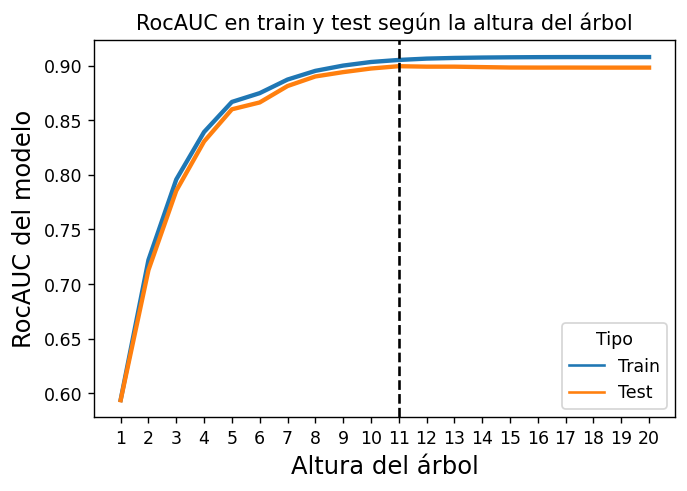

In [11]:
plt.figure(dpi=125)

sns.lineplot(data=resultados,
             x = "Altura",
             y = "RocAUC",
             hue = "Tipo",
             palette="tab10", linewidth=2.5)

maxacc_idx = resultados[resultados["Tipo"] == "Test"]["RocAUC"].idxmax(axis=0)
maxacc_altura = resultados.iloc[maxacc_idx]["Altura"]

plt.axvline(x = maxacc_altura, color="black", linestyle="--")

plt.title('RocAUC en train y test según la altura del árbol')
plt.xlabel("Altura del árbol", fontsize=14)
plt.ylabel("RocAUC del modelo", fontsize=14)
plt.xticks(range(1, 21))

plt.show()

Podemos ver que luego de una altura de 11 para el árbol de decisión  la métrica de RocAUC se mantiene medianamente constante.

[La línea negra marca el máximo valor obtenido para test]

Por el principio de la navaja de ockham, nos quedaremos con una altura de árbol en 11 para predecir la variable objetivo.

In [32]:
arbol1 = DecisionTreeClassifier(criterion='gini', min_samples_leaf=50, max_depth=11)
arbol1.fit(X_train_1, y_train_1)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=50)

Veamos un reporte de la clasificación

In [33]:
print(classification_report(y_test_1, arbol1.predict(X_test_1)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6182
           1       0.74      0.58      0.65      1959

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



Se obtuvieron resultados muy intersantes, un accuracy del 85% es superior al realizado en la primera parte del trabajo práctico.

Buenos resultados para la precisión de cada una de las clases, un poco regular el recall de unos para el modelo pero compensado por el alto recall de ceros.


Veamos la curva ROC y su puntuación AUC

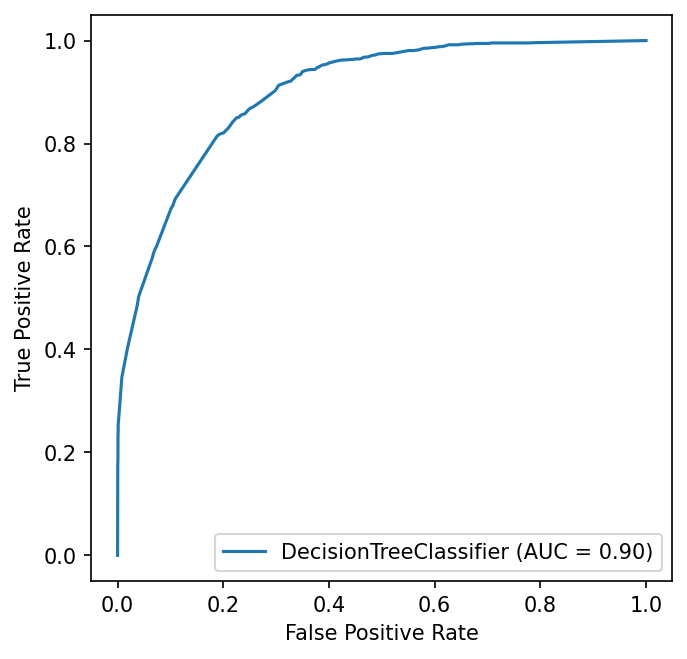

In [34]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(arbol1, X_test_1, y_test_1, ax=ax)
plt.show()

Se obtuvo una curva ROC interesante, crece bastante al principio y posee un valor de AUC de 0.90 que es bastante bueno. Concluimos que se trata de un buen modelo para empezar!

Veamos cómo queda la matriz de confusión

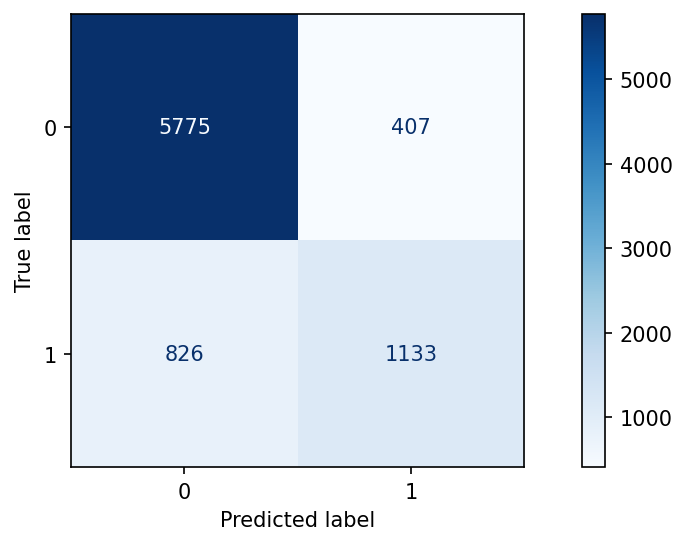

In [35]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
plot_confusion_matrix(arbol1, X_test_1, y_test_1, cmap=plt.cm.Blues, ax=ax)
plt.show()

La matriz de confusión dio decente, pero obviamente no excelente. Se puede observar que al modelo le cuesta predecir a los unos ya que a una gran parte de ellos los predice como 0.

### Modelo 2 - Preprocessing equilibrado

Este árbol será entrenado con todas las variables disponibles en el data frame, pero antes de entrenarlo se realizará un equilibrio de la variable objetivo (es decir, se desecharán gran parte de los datos de entrenamiento que no sean unos hasta que se alcace un equilibrio y sean 50% unos y 50% ceros)

Buscaremos una altura de forma similar al modelo anterior

Veamos qué sucede.

In [26]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112)

X_train_2, X_test_2, y_train_2, y_test_2 = preprocessing_equilibrado(X_train_2, X_test_2, y_train_2, y_test_2)

Similarmente se iterará la altura del árbol de forma tal que se obtenga el mejor valor de RocAUC sobre el 

In [28]:
resultados = pd.DataFrame({"Altura": [], "RocAUC": [], "Tipo": []})
    
for altura in range(1, 21):
    arbol = DecisionTreeClassifier(criterion='gini', min_samples_leaf=50, max_depth=altura)
    arbol.fit(X_train_2, y_train_2)
    resultados = resultados.append({"Altura": altura,
                      "RocAUC": roc_auc_score(y_train_2, arbol.predict_proba(X_train_2)[:,1]),
                      "Tipo": "Train"}, ignore_index=True)
    resultados = resultados.append({"Altura": altura,
                      "RocAUC": roc_auc_score(y_test_2, arbol.predict_proba(X_test_2)[:,1]),
                      "Tipo": "Test"}, ignore_index=True)


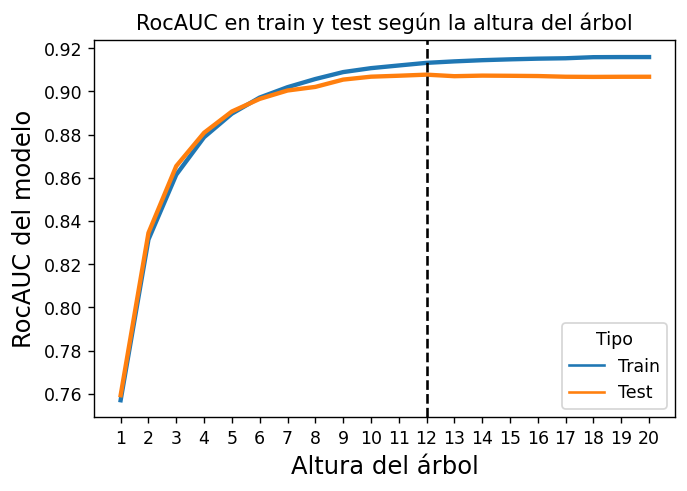

In [29]:
plt.figure(dpi=125)

sns.lineplot(data=resultados,
             x = "Altura",
             y = "RocAUC",
             hue = "Tipo",
             palette="tab10", linewidth=2.5)

maxacc_idx = resultados[resultados["Tipo"] == "Test"]["RocAUC"].idxmax(axis=0)
maxacc_altura = resultados.iloc[maxacc_idx]["Altura"]

plt.axvline(x = maxacc_altura, color="black", linestyle="--")

plt.title('RocAUC en train y test según la altura del árbol')
plt.xlabel("Altura del árbol", fontsize=14)
plt.ylabel("RocAUC del modelo", fontsize=14)
plt.xticks(range(1, 21))

plt.show()

Podemos ver que luego de una altura de 10 para el árbol de decisión la métrica de RocAUC se mantiene medianamente constante.

[La línea negra marca el máximo valor obtenido para test, este se alcanzó en 12, pero creemos que no es necesario estirarse hasta el 12, ya que con 10 ya se explica bastante similar]

Por el principio de la navaja de ockham, nos quedaremos con una altura de árbol en 10 para predecir la variable objetivo.

In [37]:
arbol2 = DecisionTreeClassifier(criterion='gini', min_samples_leaf=50, max_depth=11)
arbol2.fit(X_train_2, y_train_2)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=50)

Veamos un reporte de la clasificación

In [38]:
print(classification_report(y_test_2, arbol2.predict(X_test_2)))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      6186
           1       0.56      0.86      0.68      1955

    accuracy                           0.80      8141
   macro avg       0.75      0.82      0.77      8141
weighted avg       0.85      0.80      0.81      8141



Se obtuvieron nuevamente resultados muy intersantes, un accuracy del 80%, un valor muy inferior al obtenido en la primera parte del trabajo práctico.

Sin embargo el modelo destaca en las otras métricas, la precisión de ceros es altísima (95%). Los valores de Recall para unos es muy alto, sin embargo esto se ve opacado con el pobre valor de recall obtenido para ceros (que es la clase mayoritaria). Dados estos valores inusuales nos interesa observar cómo se comporta la curva ROC y su puntuación AUC final. Veamos

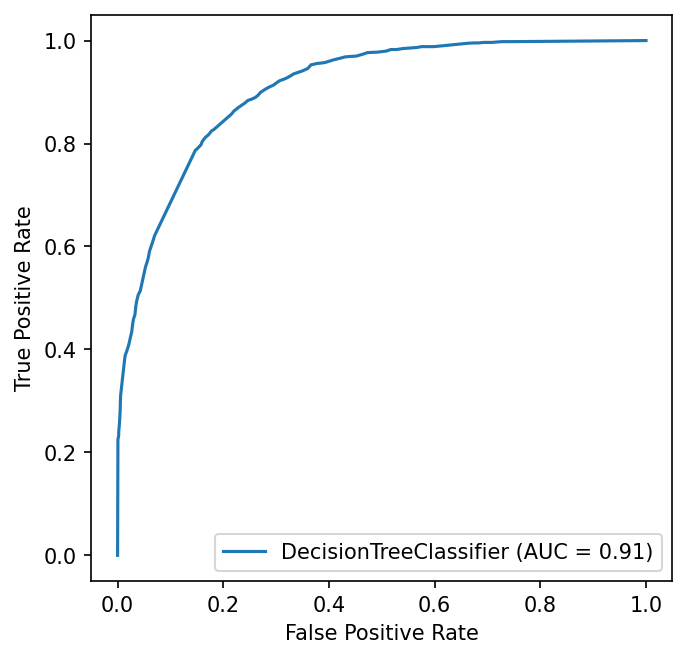

In [39]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(arbol2, X_test_2, y_test_2, ax=ax)
plt.show()

Se obtuvo un valor para AUC un punto superior al modelo anterior... esto probablemente se deba a la mejor performance del modelo para el recall de unos y la altísima precisión de ceros.

Creemos que este modelo se trata de uno muy peculiar, pero no necesariamente del mejor para precedir, basta con ver la matriz de confusión para notar lo comentado:

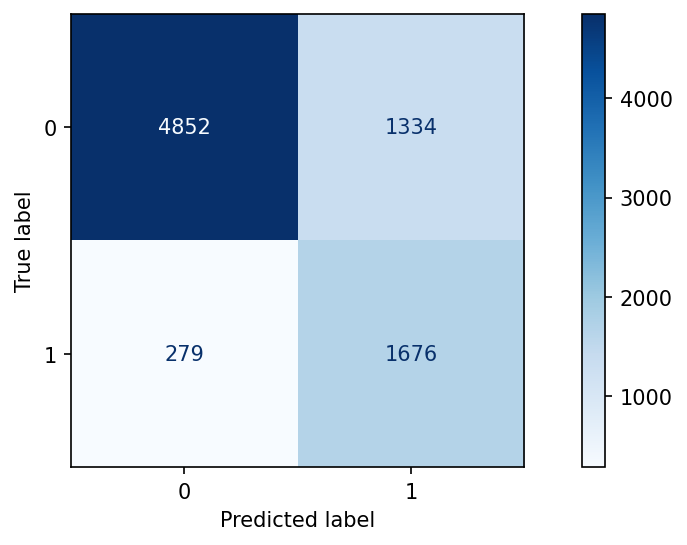

In [40]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
plot_confusion_matrix(arbol2, X_test_2, y_test_2, cmap=plt.cm.Blues, ax=ax)
plt.show()

Vemos que a diferencia de antes, son pocos los Falsos negativos. Pero aumentó muchísimo la cantidad de falsos positivos. Cuyo valor es similar al de verdaderos positivos.

Además que el accuracy es muy pobre (ya que se pierden muchos ceros)

# Persistiendo los modelos

In [11]:
import pickle

In [45]:
pickle.dump(arbol1, open("Modelos/Tree/tree1.pickle", "wb"))
pickle.dump(arbol2, open("Modelos/Tree/tree2.pickle", "wb"))

# Predicción de HoldOut

Usaremos para predecir el árbol obtenido para el preprocessing equilibrado.

In [18]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv, drop_first=True)

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X, drop_first=True)
    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    return ids, X

In [19]:
arbol2 = pickle.load(open("Modelos/Tree/tree2.pickle", "rb"))

In [20]:
ids, X = holdout()

In [21]:
utils.escribir_holdout(arbol2.predict(X), "1 - Tree", ids)